In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

In [1]:
import tensorflow as tf

# Set memory growth BEFORE any TensorFlow operations
physical_devices = tf.config.list_physical_devices('GPU')
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(physical_devices))
if len(physical_devices) > 0:
    print("GPU detected:", physical_devices)
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)  # Set memory growth
else:
    print("No GPU detected. Running on CPU.")

TensorFlow version: 2.10.1
Num GPUs Available: 1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Paths
train_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\train'
val_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\val'
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'

In [4]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

In [5]:
# Data augmentation with random parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,              # Random rotation between -40 to 40 degrees
    width_shift_range=0.3,         # Random width shift up to 30%
    height_shift_range=0.3,        # Random height shift up to 30%
    shear_range=0.2,              # Random shear transformation
    zoom_range=[0.7, 1.3],        # Random zoom in/out between 70% and 130%
    brightness_range=[0.7, 1.3],  # Random brightness adjustment
    horizontal_flip=True,         # Random horizontal flips
    vertical_flip=True,          # Random vertical flips
    fill_mode='nearest',         # Fill mode for new pixels
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape)  # Random noise
)

In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 12137 images belonging to 7 classes.
Found 3474 images belonging to 7 classes.
Found 1737 images belonging to 7 classes.


In [7]:
# Model setup
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [10]:
# Initial training
print(f"Initial training for {INITIAL_EPOCHS} epochs...")
history_initial = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping]
)

Initial training for 10 epochs...
Epoch 1/10
380/380 [==============================] - 258s 628ms/step - loss: 1.9543 - accuracy: 0.1613 - val_loss: 1.8903 - val_accuracy: 0.1989
Epoch 2/10
380/380 [==============================] - 238s 625ms/step - loss: 1.9199 - accuracy: 0.1717 - val_loss: 1.8710 - val_accuracy: 0.2121
Epoch 3/10
380/380 [==============================] - 235s 619ms/step - loss: 1.9115 - accuracy: 0.1724 - val_loss: 1.8743 - val_accuracy: 0.1929
Epoch 4/10
380/380 [==============================] - 222s 583ms/step - loss: 1.9019 - accuracy: 0.1792 - val_loss: 1.8598 - val_accuracy: 0.2001
Epoch 5/10
380/380 [==============================] - 216s 567ms/step - loss: 1.9024 - accuracy: 0.1872 - val_loss: 1.8782 - val_accuracy: 0.2237
Epoch 6/10
380/380 [==============================] - 224s 589ms/step - loss: 1.8979 - accuracy: 0.1885 - val_loss: 1.8441 - val_accuracy: 0.2366
Epoch 7/10
380/380 [==============================] - 226s 594ms/step - loss: 1.8954 - acc

In [11]:
# Fine-tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nFine-tuning for {FINE_TUNE_EPOCHS} epochs...")
history_fine = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=INITIAL_EPOCHS,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping]
)


Fine-tuning for 20 epochs...
Epoch 11/30
380/380 [==============================] - 224s 578ms/step - loss: 1.9803 - accuracy: 0.1577 - val_loss: 1.9557 - val_accuracy: 0.1606
Epoch 12/30
380/380 [==============================] - 214s 563ms/step - loss: 1.9412 - accuracy: 0.1525 - val_loss: 1.9266 - val_accuracy: 0.1600
Epoch 13/30
380/380 [==============================] - 235s 619ms/step - loss: 1.9129 - accuracy: 0.1777 - val_loss: 1.8728 - val_accuracy: 0.1819
Epoch 14/30
380/380 [==============================] - 241s 636ms/step - loss: 1.9080 - accuracy: 0.1804 - val_loss: 1.8576 - val_accuracy: 0.2107
Epoch 15/30
380/380 [==============================] - 234s 616ms/step - loss: 1.8892 - accuracy: 0.1919 - val_loss: 1.8225 - val_accuracy: 0.2524
Epoch 16/30
380/380 [==============================] - 240s 632ms/step - loss: 1.8652 - accuracy: 0.2220 - val_loss: 1.8020 - val_accuracy: 0.2599
Epoch 17/30
380/380 [==============================] - 247s 650ms/step - loss: 1.8582 - 

In [12]:
# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

55/55 [==============================] - 24s 444ms/step - loss: 1.5857 - accuracy: 0.3771

Test accuracy: 0.3771
Test loss: 1.5857


In [13]:
# Save model
model.save('resnet50_7classes_model.h5')


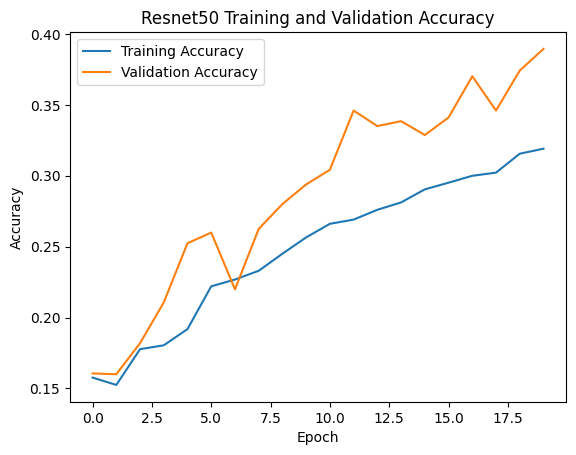

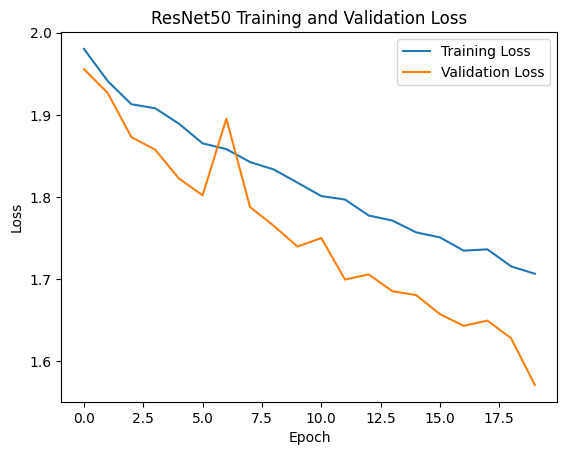

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Resnet50 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels and predictions
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Found 1737 images belonging to 7 classes.
55/55 [==============================] - 13s 219ms/step
Accuracy: 37.71%
Precision: 0.4242
Recall: 0.3771
F1-Score: 0.3494

Classification Report:
                  precision    recall  f1-score   support

Bacterial Blight       0.39      0.60      0.47       250
      Brown Spot       0.77      0.22      0.35       242
         Healthy       0.31      0.62      0.41       249
           Hispa       0.53      0.28      0.37       247
      Leaf Blast       0.29      0.08      0.13       250
   Sheath Blight       0.31      0.21      0.25       249
          Tungro       0.38      0.62      0.47       250

        accuracy                           0.38      1737
       macro avg       0.43      0.38      0.35      1737
    weighted avg       0.42      0.38      0.35      1737


Confusion Matrix:
[[150   0  39   9  16  15  21]
 [ 50  54  69   3  14  18  34]
 [ 21   0 154  16   7   8  43]
 [ 15   0 101  70   1  31  29]
 [ 56  16  46  12  21  23  

Found 1737 images belonging to 7 classes.
55/55 [==============================] - 12s 223ms/step


<Figure size 1000x800 with 0 Axes>

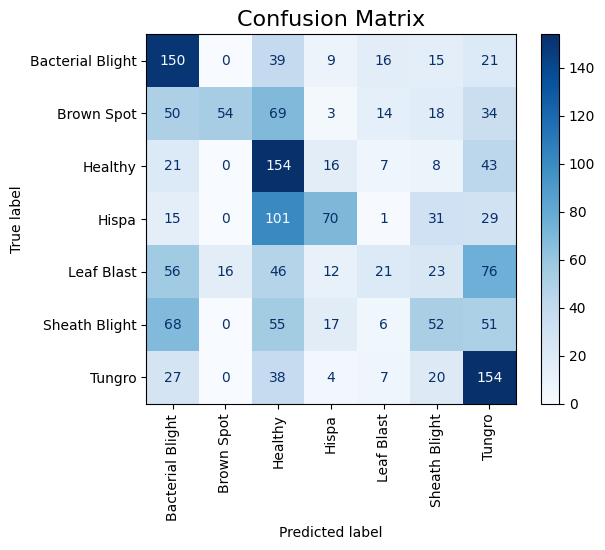

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.classes  # True labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(test_ds.class_indices.keys())  # Get class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.title('Confusion Matrix', fontsize=16)
plt.show()

Found 1737 images belonging to 7 classes.
55/55 [==============================] - 13s 232ms/step


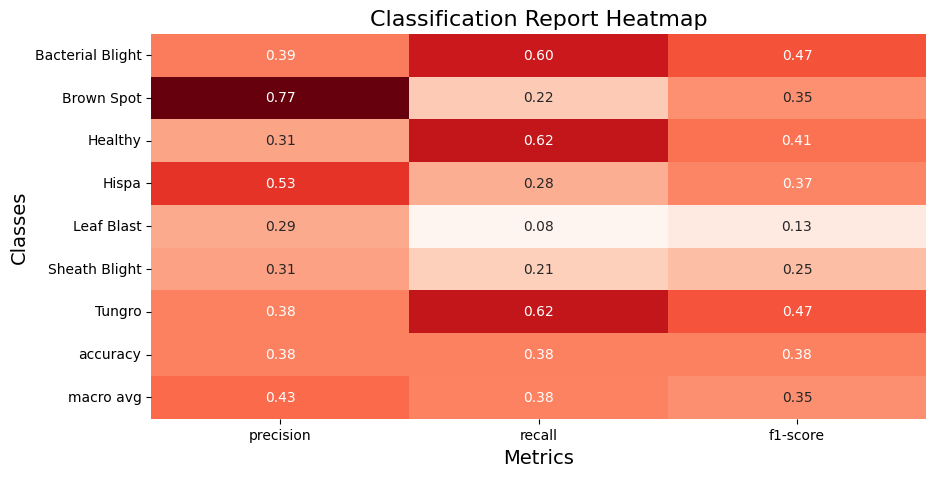

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.classes  # True labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Generate a classification report
report = classification_report(true_labels, pred_labels, target_names=list(test_ds.class_indices.keys()), output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap=plt.cm.Reds, fmt=".2f", cbar=False)
plt.title('Classification Report Heatmap', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Classes', fontsize=14)
plt.show()